In [10]:
import neuralnetwork
from neuralnetwork import FFNN 
from neuralnetwork import Sigmoid
from neuralnetwork import MSE
from neuralnetwork import Adam
from neuralnetwork import Activations
from neuralnetwork import Constant
from neuralnetwork import RMS_prop
from neuralnetwork import RELU
from neuralnetwork import LRELU
from neuralnetwork import cost_functions
import math
import autograd.numpy as np
import sys
import warnings
from autograd import grad, elementwise_grad
from random import random, seed
from copy import deepcopy, copy
from typing import Tuple, Callable
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [11]:
#Create Runge dataset

#Setting up the input to use on the neural network script imported, using Runges Function

#Importing packages
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

#Random seed to keep the results consistent 
np.random.seed(2030)

def Runge():
    n = 500
    x = np.linspace(-1,1,n).reshape(-1,1) #interval between -1 and 1 formatted to fit in shape with the neural network
    denominator = 1 + (25*x**2) 
    y = 1 / denominator #will not add noise right now
    return x, y  

x, y = Runge()

#Setting up the design matrix is not necessary since we are using the neural network 
#But we still need to do some scaling
Xtrain, Xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
#Scale data 
Scaling = StandardScaler(with_std = True)
Scaling.fit(Xtrain)
Xtrain = Scaling.transform(Xtrain)
Xtest = Scaling.transform(Xtest)
ymin, ymax = ytrain.min(), ytrain.max()
ytrain = (ytrain - ymin) / (ymax - ymin)
ytest = (ytest - ymin) / (ymax - ymin)

In [12]:
#Quick function to decide wheter to use L1 or L2 norm: 
def cost(norm_type = None):
    cost_norm = MSE()
    cost_norm.norm = norm_type
    return cost_norm


In [13]:
results_learning_rates_Sigmoid_L1 = []
#train only for Adam and RMSprop and plot individually for different lambdas and etas
for layers, label in [
    ((1,50,1), '1 Hidden Layer'),
    ((1,50,100,1), '2 Hidden Layers')
    ]:

    for lr in [0.01, 0.001, 0.0065, 0.0001]:
        optimizer = [
            Adam(eta=lr, rho = 0.9, rho2=0.999), #vals chosen based on Geeks for Geeks source on Adam optimization
            RMS_prop(eta = lr, rho = 0.9)
        ]

        for o in optimizer:
            for lmd in [0.5, 0.1, 0.05, 0.01]:
                nn = FFNN(
                    nodes = layers,
                    hidden_activation= Sigmoid(),
                    output_activation= lambda x: x, 
                    cost_func = cost('L1')
                )

                res = nn.fit(
                    X = Xtrain, 
                    t = ytrain,
                    scheduler = o, 
                    batches = 4, 
                    epochs = 2000, 
                    lam = lmd
                )

                ypred = nn.predict(Xtest)
                test_error = np.mean((ytest - ypred))**2 #MSE
                results_learning_rates_Sigmoid_L1.append({
                    'layers': label,
                    'lr': lr,
                    'lambda' : lmd,
                    'optimizer': o.__class__.__name__,
                    'Test error': test_error,
                    'Train error': res['train_errors'][-1]
                    })

Adam: Eta=0.01, Lambda=0.5
  [=======================================>] 100.0% | train_error: 81.5   Adam: Eta=0.01, Lambda=0.1
  [=======================================>] 100.0% | train_error: 69.1   Adam: Eta=0.01, Lambda=0.05
  [=======================================>] 100.0% | train_error: 37.8   Adam: Eta=0.01, Lambda=0.01
  [=======================================>] 100.0% | train_error: 9.13   RMS_prop: Eta=0.01, Lambda=0.5
  [=======================================>] 100.0% | train_error: 444    RMS_prop: Eta=0.01, Lambda=0.1
  [=======================================>] 100.0% | train_error: 121 0  RMS_prop: Eta=0.01, Lambda=0.05
  [=======================================>] 100.0% | train_error: 66.5   RMS_prop: Eta=0.01, Lambda=0.01
  [=======================================>] 100.0% | train_error: 15.3    Adam: Eta=0.001, Lambda=0.5
  [=======================================>] 100.0% | train_error: 29.1   Adam: Eta=0.001, Lambda=0.1
  [======================================

In [14]:

def heatmap_reg(results,optimizer, plotting_val):
    df = pd.DataFrame(results)
    print(df)
    df = df.sort_values(['optimizer', 'layers', 'lr', 'lambda'])
    sub = df[df['optimizer'] == optimizer]
    layers = sub['layers'].unique()
    fig, axes = plt.subplots(1,2, figsize = (12,5))
    
    if len(layers) == 1:
        axes = [axes]

    for ax, layer in zip(axes, layers):
        df_layer = sub[sub['layers'] == layer]
        pivot = df_layer.pivot(index = 'lambda', columns = 'lr', values = plotting_val)

        sns.heatmap(pivot, annot = True, cmap = 'rocket_r', fmt = '.3f', ax = ax)
        ax.set_title(f'{plotting_val} using {optimizer} for {layer}')
        ax.set_xlabel(fr'Learning rates $\mu$')
        ax.set_ylabel(fr'Lambda $\lambda$')
    plt.tight_layout()
    plt.show()

             layers      lr  lambda optimizer  Test error  Train error
0    1 Hidden Layer  0.0100    0.50      Adam    0.009684    81.530670
1    1 Hidden Layer  0.0100    0.10      Adam    0.000383    69.127286
2    1 Hidden Layer  0.0100    0.05      Adam    0.001491    37.828155
3    1 Hidden Layer  0.0100    0.01      Adam    0.000679     9.128285
4    1 Hidden Layer  0.0100    0.50  RMS_prop    0.006207   444.108706
..              ...     ...     ...       ...         ...          ...
59  2 Hidden Layers  0.0001    0.01      Adam    0.007604     0.616237
60  2 Hidden Layers  0.0001    0.50  RMS_prop    0.271558   150.595924
61  2 Hidden Layers  0.0001    0.10  RMS_prop    0.007684    25.958274
62  2 Hidden Layers  0.0001    0.05  RMS_prop    0.000152    11.454688
63  2 Hidden Layers  0.0001    0.01  RMS_prop    0.008893     2.035744

[64 rows x 6 columns]


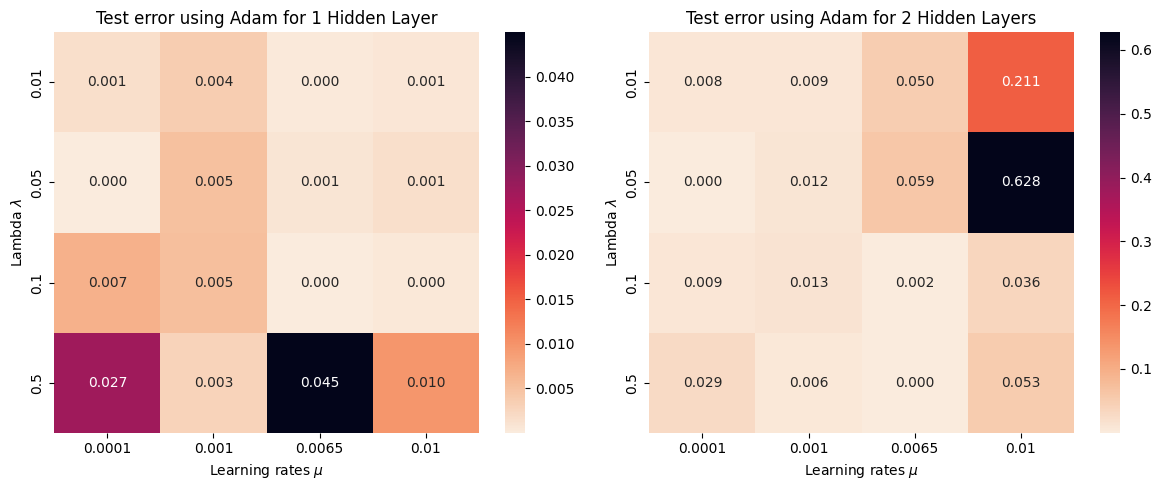

             layers      lr  lambda optimizer  Test error  Train error
0    1 Hidden Layer  0.0100    0.50      Adam    0.009684    81.530670
1    1 Hidden Layer  0.0100    0.10      Adam    0.000383    69.127286
2    1 Hidden Layer  0.0100    0.05      Adam    0.001491    37.828155
3    1 Hidden Layer  0.0100    0.01      Adam    0.000679     9.128285
4    1 Hidden Layer  0.0100    0.50  RMS_prop    0.006207   444.108706
..              ...     ...     ...       ...         ...          ...
59  2 Hidden Layers  0.0001    0.01      Adam    0.007604     0.616237
60  2 Hidden Layers  0.0001    0.50  RMS_prop    0.271558   150.595924
61  2 Hidden Layers  0.0001    0.10  RMS_prop    0.007684    25.958274
62  2 Hidden Layers  0.0001    0.05  RMS_prop    0.000152    11.454688
63  2 Hidden Layers  0.0001    0.01  RMS_prop    0.008893     2.035744

[64 rows x 6 columns]


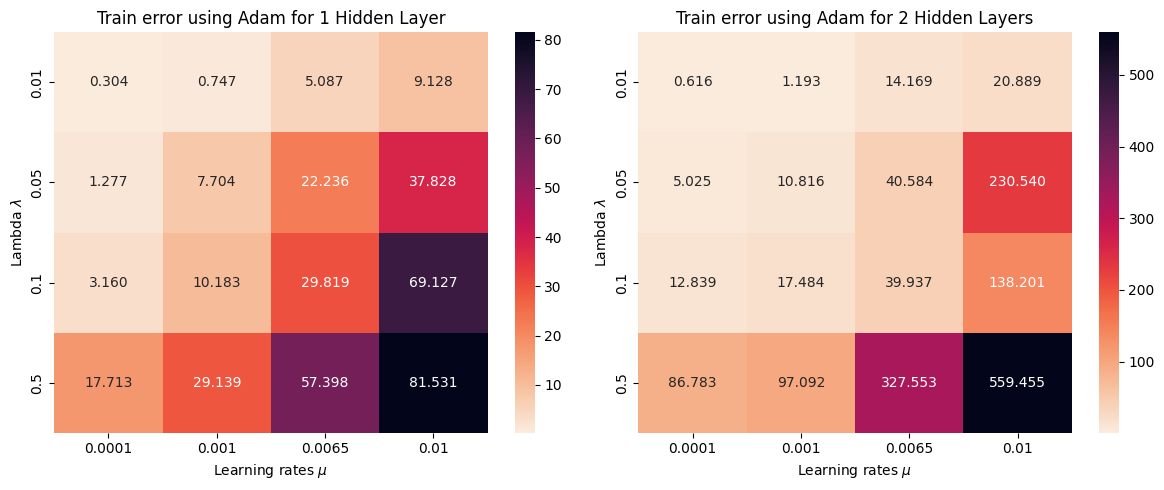

             layers      lr  lambda optimizer  Test error  Train error
0    1 Hidden Layer  0.0100    0.50      Adam    0.009684    81.530670
1    1 Hidden Layer  0.0100    0.10      Adam    0.000383    69.127286
2    1 Hidden Layer  0.0100    0.05      Adam    0.001491    37.828155
3    1 Hidden Layer  0.0100    0.01      Adam    0.000679     9.128285
4    1 Hidden Layer  0.0100    0.50  RMS_prop    0.006207   444.108706
..              ...     ...     ...       ...         ...          ...
59  2 Hidden Layers  0.0001    0.01      Adam    0.007604     0.616237
60  2 Hidden Layers  0.0001    0.50  RMS_prop    0.271558   150.595924
61  2 Hidden Layers  0.0001    0.10  RMS_prop    0.007684    25.958274
62  2 Hidden Layers  0.0001    0.05  RMS_prop    0.000152    11.454688
63  2 Hidden Layers  0.0001    0.01  RMS_prop    0.008893     2.035744

[64 rows x 6 columns]


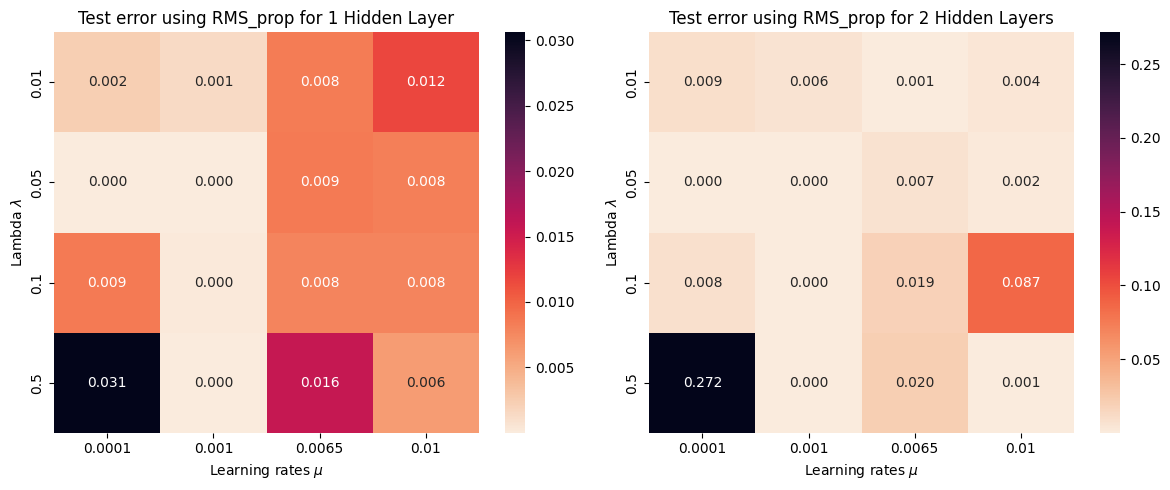

             layers      lr  lambda optimizer  Test error  Train error
0    1 Hidden Layer  0.0100    0.50      Adam    0.009684    81.530670
1    1 Hidden Layer  0.0100    0.10      Adam    0.000383    69.127286
2    1 Hidden Layer  0.0100    0.05      Adam    0.001491    37.828155
3    1 Hidden Layer  0.0100    0.01      Adam    0.000679     9.128285
4    1 Hidden Layer  0.0100    0.50  RMS_prop    0.006207   444.108706
..              ...     ...     ...       ...         ...          ...
59  2 Hidden Layers  0.0001    0.01      Adam    0.007604     0.616237
60  2 Hidden Layers  0.0001    0.50  RMS_prop    0.271558   150.595924
61  2 Hidden Layers  0.0001    0.10  RMS_prop    0.007684    25.958274
62  2 Hidden Layers  0.0001    0.05  RMS_prop    0.000152    11.454688
63  2 Hidden Layers  0.0001    0.01  RMS_prop    0.008893     2.035744

[64 rows x 6 columns]


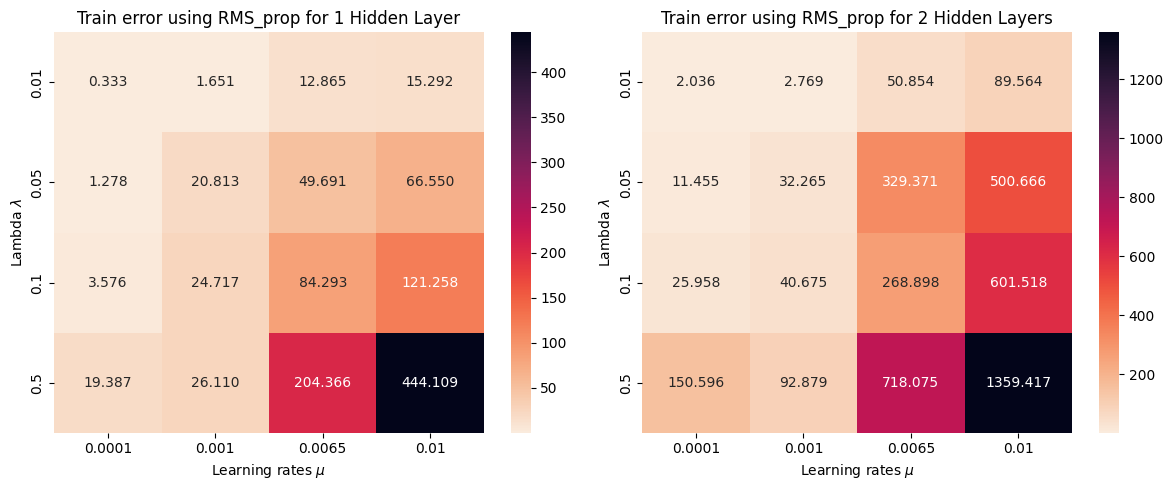

In [15]:
#For L1 norms
for o in ['Adam', 'RMS_prop']:
    for t in ['Test error', 'Train error']:
        heatmap_reg(results_learning_rates_Sigmoid_L1, o, t)

In [16]:
results_learning_rates_Sigmoid_L2 = []
#train only for Adam and RMSprop and plot individually for different lambdas and etas
for layers, label in [
    ((1,50,1), '1 Hidden Layer'),
    ((1,50,100,1), '2 Hidden Layers')
    ]:

    for lr in [0.01, 0.001, 0.0065, 0.0001]:
        optimizer = [
            Adam(eta=lr, rho = 0.9, rho2=0.999), #vals chosen based on Geeks for Geeks source on Adam optimization
            RMS_prop(eta = lr, rho = 0.9)
        ]

        for o in optimizer:
            for lmd in [0.5, 0.1, 0.05, 0.01]:
                nn = FFNN(
                    nodes = layers,
                    hidden_activation= Sigmoid(),
                    output_activation= lambda x: x, 
                    cost_func = cost('L2')
                )

                res = nn.fit(
                    X = Xtrain, 
                    t = ytrain,
                    scheduler = o, 
                    batches = 4, 
                    epochs = 2000, 
                    lam = lmd
                )

                ypred = nn.predict(Xtest)
                test_error = np.mean((ytest - ypred))**2 #MSE
                results_learning_rates_Sigmoid_L2.append({
                    'layers': label,
                    'lr': lr,
                    'lambda' : lmd,
                    'optimizer': o.__class__.__name__,
                    'Test error': test_error,
                    'Train error': res['train_errors'][-1]
                    })

Adam: Eta=0.01, Lambda=0.5
  [=======================================>] 100.0% | train_error: 8108   Adam: Eta=0.01, Lambda=0.1
  [=======================================>] 100.0% | train_error: 1658   Adam: Eta=0.01, Lambda=0.05
  [=======================================>] 100.0% | train_error: 631 0  Adam: Eta=0.01, Lambda=0.01
  [=======================================>] 100.0% | train_error: 88.6   RMS_prop: Eta=0.01, Lambda=0.5
  [=======================================>] 100.0% | train_error: 27609  RMS_prop: Eta=0.01, Lambda=0.1
  [=======================================>] 100.0% | train_error: 6571   RMS_prop: Eta=0.01, Lambda=0.05
  [=======================================>] 100.0% | train_error: 3451   RMS_prop: Eta=0.01, Lambda=0.01
  [=======================================>] 100.0% | train_error: 501     Adam: Eta=0.001, Lambda=0.5
  [=======================================>] 100.0% | train_error: 418    Adam: Eta=0.001, Lambda=0.1
  [======================================

             layers      lr  lambda optimizer  Test error   Train error
0    1 Hidden Layer  0.0100    0.50      Adam    0.022159   8108.081245
1    1 Hidden Layer  0.0100    0.10      Adam    0.004031   1658.246039
2    1 Hidden Layer  0.0100    0.05      Adam    0.008863    631.393843
3    1 Hidden Layer  0.0100    0.01      Adam    0.043233     88.630386
4    1 Hidden Layer  0.0100    0.50  RMS_prop    0.008858  27609.350553
..              ...     ...     ...       ...         ...           ...
59  2 Hidden Layers  0.0001    0.01      Adam    0.008813      0.306191
60  2 Hidden Layers  0.0001    0.50  RMS_prop    0.002165    173.880723
61  2 Hidden Layers  0.0001    0.10  RMS_prop    0.007513     18.521542
62  2 Hidden Layers  0.0001    0.05  RMS_prop    0.008444      6.588839
63  2 Hidden Layers  0.0001    0.01  RMS_prop    0.009126      1.265429

[64 rows x 6 columns]


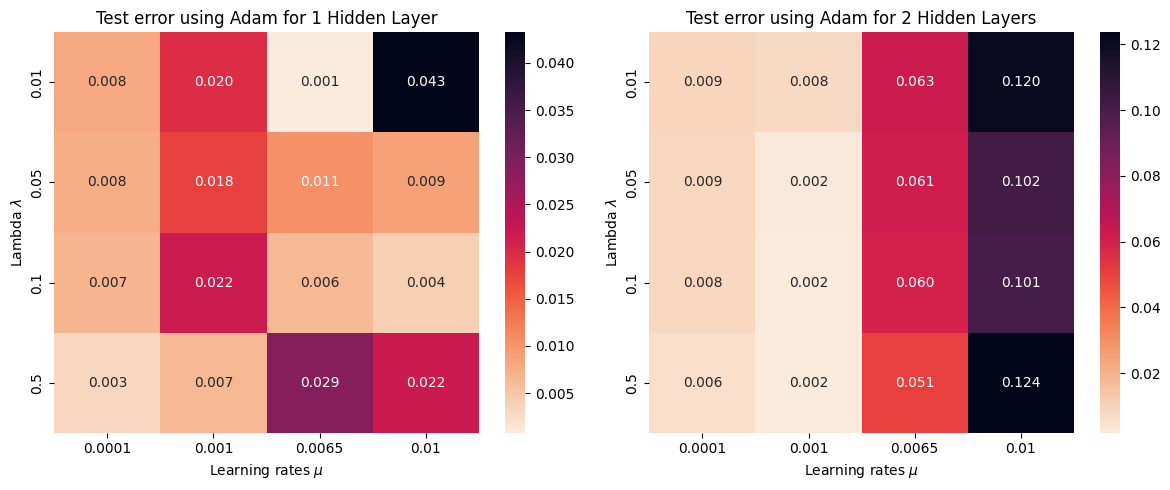

             layers      lr  lambda optimizer  Test error   Train error
0    1 Hidden Layer  0.0100    0.50      Adam    0.022159   8108.081245
1    1 Hidden Layer  0.0100    0.10      Adam    0.004031   1658.246039
2    1 Hidden Layer  0.0100    0.05      Adam    0.008863    631.393843
3    1 Hidden Layer  0.0100    0.01      Adam    0.043233     88.630386
4    1 Hidden Layer  0.0100    0.50  RMS_prop    0.008858  27609.350553
..              ...     ...     ...       ...         ...           ...
59  2 Hidden Layers  0.0001    0.01      Adam    0.008813      0.306191
60  2 Hidden Layers  0.0001    0.50  RMS_prop    0.002165    173.880723
61  2 Hidden Layers  0.0001    0.10  RMS_prop    0.007513     18.521542
62  2 Hidden Layers  0.0001    0.05  RMS_prop    0.008444      6.588839
63  2 Hidden Layers  0.0001    0.01  RMS_prop    0.009126      1.265429

[64 rows x 6 columns]


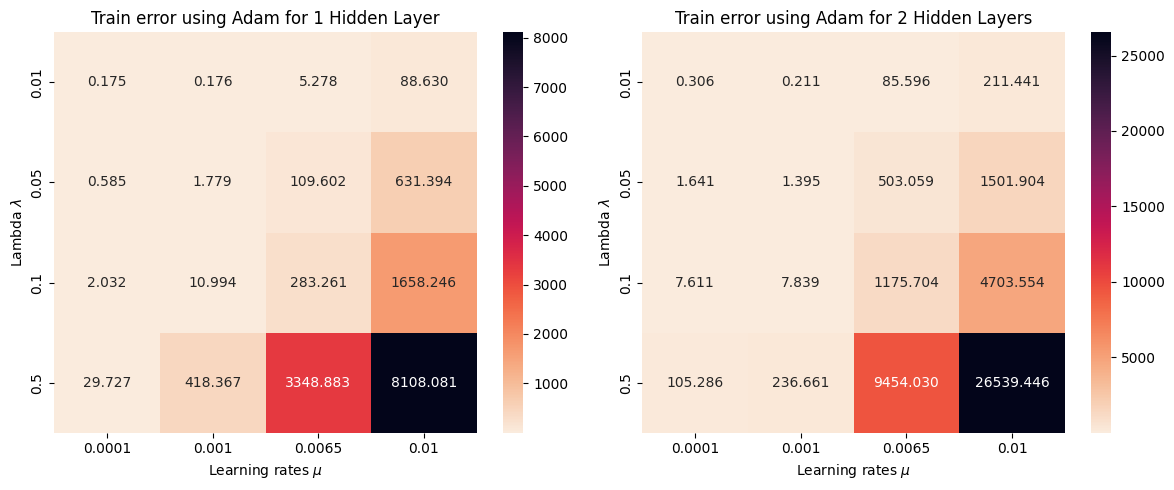

             layers      lr  lambda optimizer  Test error   Train error
0    1 Hidden Layer  0.0100    0.50      Adam    0.022159   8108.081245
1    1 Hidden Layer  0.0100    0.10      Adam    0.004031   1658.246039
2    1 Hidden Layer  0.0100    0.05      Adam    0.008863    631.393843
3    1 Hidden Layer  0.0100    0.01      Adam    0.043233     88.630386
4    1 Hidden Layer  0.0100    0.50  RMS_prop    0.008858  27609.350553
..              ...     ...     ...       ...         ...           ...
59  2 Hidden Layers  0.0001    0.01      Adam    0.008813      0.306191
60  2 Hidden Layers  0.0001    0.50  RMS_prop    0.002165    173.880723
61  2 Hidden Layers  0.0001    0.10  RMS_prop    0.007513     18.521542
62  2 Hidden Layers  0.0001    0.05  RMS_prop    0.008444      6.588839
63  2 Hidden Layers  0.0001    0.01  RMS_prop    0.009126      1.265429

[64 rows x 6 columns]


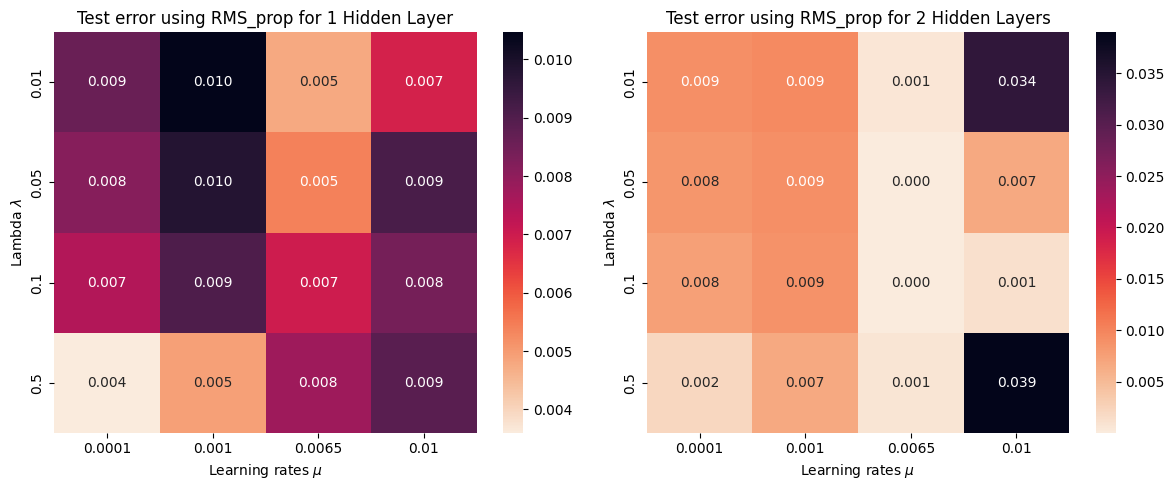

             layers      lr  lambda optimizer  Test error   Train error
0    1 Hidden Layer  0.0100    0.50      Adam    0.022159   8108.081245
1    1 Hidden Layer  0.0100    0.10      Adam    0.004031   1658.246039
2    1 Hidden Layer  0.0100    0.05      Adam    0.008863    631.393843
3    1 Hidden Layer  0.0100    0.01      Adam    0.043233     88.630386
4    1 Hidden Layer  0.0100    0.50  RMS_prop    0.008858  27609.350553
..              ...     ...     ...       ...         ...           ...
59  2 Hidden Layers  0.0001    0.01      Adam    0.008813      0.306191
60  2 Hidden Layers  0.0001    0.50  RMS_prop    0.002165    173.880723
61  2 Hidden Layers  0.0001    0.10  RMS_prop    0.007513     18.521542
62  2 Hidden Layers  0.0001    0.05  RMS_prop    0.008444      6.588839
63  2 Hidden Layers  0.0001    0.01  RMS_prop    0.009126      1.265429

[64 rows x 6 columns]


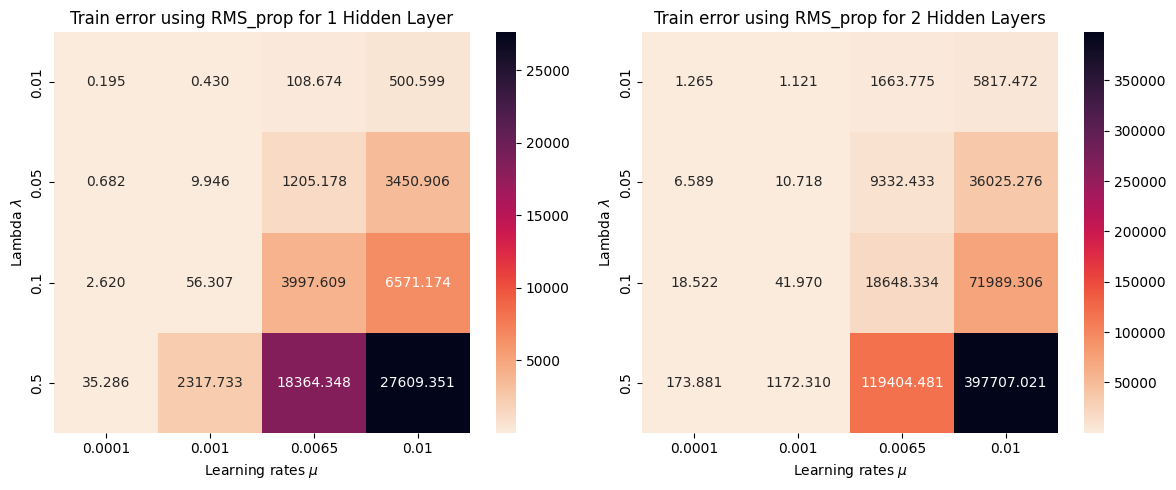

In [18]:
#For L2 norms
for o in ['Adam', 'RMS_prop']:
    for t in ['Test error', 'Train error']:
        heatmap_reg(results_learning_rates_Sigmoid_L2, o, t)